
# Multi-Compartment Halophyte Hydraulic Model

This notebook runs the multi-compartment halophyte groundwater model with salt dynamics using weather data.

**Model Features:**
- Multi-compartment soil system with independent moisture and salt dynamics
- Bartlett et al. (2012) plant water potential formulation
- Algebraic water balance enforcement at root/soil interface
- Numerical water balance at xylem junction

**Key Parameters:**
- Duration: Simulation length in days
- Initial soil moisture and salt concentrations per compartment
- Root distribution across compartments
- Plant storage initial conditions

In [3]:

# Import required libraries
import os
import numpy as np
import pandas as pd
from math import exp, pi, sqrt, log
import matplotlib.pyplot as plt
import importlib

# Import model components
from dics import *
from functions import *
from species_traits import *

# Import multi-compartment classes
from soil import SoilMultiple, Loam, DrydownSoil
from hydraulics import Halophyte
from defs import SimulationMultiComp, Atmosphere, steps
from photosynthesis import C3

print("Libraries imported successfully")

Libraries imported successfully


## Configuration & Parameter Setup
Define simulation parameters for multi-compartment system.

In [25]:

# Simulation configuration
duration = 30  # Simulation duration (days)
timestepM = 30  # Model timestep (minutes)
dt = timestepM * 60.0  # Convert to seconds

# Weather data file
weatherFile = r"sample_data\AgadirInterp30.xlsx"

# Multi-compartment configuration
num_compartments = 2
zr_arr = np.array([1.0, 1.0])  # Root zone depth for each compartment (m)
s_init_arr = np.array([0.5, 0.5])  # Initial soil moisture for each compartment
cs_init_arr = np.array([0, 150.])  # Initial salt concentration (Mol/m³)
root_frac_arr = np.array([0.5, 0.5])  # Root fraction in each compartment

# Hydraulic parameters
B_param = 500  # Root conductance scaling parameter

# Plant water potential parameters (Bartlett et al. 2012)
wr = 0.1  # Wilting point relative water content
wft = 1.0  # Full turgor relative water content
pi0 = -1.5  # Osmotic potential at full turgor (MPa)
eta = 5  # Elastic modulus shape parameter
mcap = 12  # Slope of linear portion of psi_wf curve

# Plant initial conditions
vwi = 0.95  # Initial storage volume fraction
cw_init = 150.  # Initial plant salt concentration (Mol/m³)

print(f"Simulation duration: {duration} days")
print(f"Timestep: {timestepM} minutes")
print(f"Number of compartments: {num_compartments}")
print(f"Root distribution: {root_frac_arr}")
print(f"Initial soil moisture: {s_init_arr}")
print(f"Initial salt concentrations: {cs_init_arr} Mol/m³")

Simulation duration: 30 days
Timestep: 30 minutes
Number of compartments: 2
Root distribution: [0.5 0.5]
Initial soil moisture: [0.5 0.5]
Initial salt concentrations: [  0. 150.] Mol/m³


## Load Weather Data
Read weather input from Excel file (temperature, humidity, solar radiation).

In [26]:
# Load weather data from Excel
df = pd.read_excel(weatherFile, engine='openpyxl')

# Extract and convert temperature to Kelvin
tempC = df['Temperature']  # in Celsius
taInp = tempC + 273.0
taInp = list(taInp.values)

# Extract relative humidity and convert to specific humidity (kg/kg)
rh = df['Relative Humidity']  # in %
A_SAT = 611.2  # Pa
B_SAT = 17.67
C_SAT = 243.5  # °C
P_ATM = 101325  # Pa
psat = A_SAT * np.exp((B_SAT * tempC) / (C_SAT + tempC))  # Saturated vapor pressure (Pa)
qaInp = 0.622 * rh / 100.0 * psat / P_ATM
qaInp = list(qaInp.values)

# Extract solar radiation (global horizontal irradiance)
phiInp = list(df['GHI'].values)  # W/m²

print(f"Weather data loaded: {len(taInp)} timesteps")
print(f"Temperature range: {min(tempC):.1f} - {max(tempC):.1f} °C")
print(f"Solar radiation range: {min(phiInp):.1f} - {max(phiInp):.1f} W/m²")

Weather data loaded: 17521 timesteps
Temperature range: 11.0 - 33.1 °C
Solar radiation range: 0.0 - 781.9 W/m²



## Initialize Model Components
Set up species, soil, atmosphere, photosynthesis, and hydraulic components.


In [27]:
# Species and atmosphere setup
species = Pmenz()  # Douglas fir, Pseudotsuga menziesii
atmosphere = Atmosphere(phiInp[0], taInp[0], qaInp[0])

# Create multi-compartment soil with salt dynamics
soil = SoilMultiple(
    stype=Loam(),  # Broadcast to all compartments
    dynamics=DrydownSoil(),  # Broadcast to all compartments
    zr=zr_arr,
    s=s_init_arr,
    cs=cs_init_arr
)

# Create photosynthesis model
photo = C3(species, atmosphere)

# Create hydraulic model
hydro = Halophyte(
    species=species,
    atm=atmosphere,
    soil=soil,
    photo=photo,
    vwi=vwi,
    cw=cw_init,
    s_arr=s_init_arr,
    root_frac_arr=root_frac_arr,
    B=B_param,
    cs_arr=cs_init_arr,
    wr=wr,
    wft=wft,
    pi0=pi0,
    eta=eta,
    mcap=mcap,
    dt=dt
)

print("Model components initialized:")
print(f"  Initial plant water content: {hydro.w:.3f}")
print(f"  Initial plant salt concentration: {hydro.cw:.1f} Mol/m³")
print(f"  Initial leaf water potential: {hydro.psi_l:.3f} MPa")

# Create simulation wrapper
plant = SimulationMultiComp(
    species_cls=species,
    atm_cls=atmosphere,
    soil_cls=soil,
    photo_cls=photo,
    hydro_cls=hydro,
    zr_arr=zr_arr,
    root_frac_arr=root_frac_arr,
    B=B_param,
    dt=dt
)

print("\nSimulation initialized successfully")

Model components initialized:
  Initial plant water content: 0.950
  Initial plant salt concentration: 150.0 Mol/m³
  Initial leaf water potential: -0.417 MPa

Simulation initialized successfully


## Run Simulation
Advance the model through each timestep using weather data.

In [28]:
# Run simulation
print(f"\nRunning simulation for {duration} days...")
n_steps = steps(duration, int(timestepM))

for i in range(n_steps):
    plant.update(dt, phiInp[i], taInp[i], qaInp[i])
    
    # Progress indicator
    if (i + 1) % (n_steps // 4) == 0 or i == 0:
        print(f"  Completed {i+1}/{n_steps} timesteps ({(i+1)/n_steps*100:.1f}%)")

print("Simulation complete!")

# Extract results
results = plant.output()

print(f"\nResults extracted. Available keys: {list(results.keys())}")


Running simulation for 30 days...
  Completed 1/1440 timesteps (0.1%)
  Completed 360/1440 timesteps (25.0%)
  Completed 720/1440 timesteps (50.0%)
  Completed 1080/1440 timesteps (75.0%)
  Completed 1440/1440 timesteps (100.0%)
Simulation complete!

Results extracted. Available keys: ['a', 'psi_l', 'qs', 'gp', 'gsr', 'gsw', 'tl', 'ev', 'ev_cum', 'qw', 'vw', 'cw', 'psi_w', 'psi_w_turgor', 'psi_w_osm', 'psi_x', 'psi_b', 'gwf', 'w', 'flux_balance', 'hr_cum', 'Uptake', 'MW', 'delta psi w', 'qbx', 's', 'psi_s', 'cs']


## Water Balance Diagnostics
Check water balance closure at nodes B (root/soil interface) and X (xylem junction).

In [30]:
# Calculate water balance at both nodes
node_b_balance = (np.array(results['qbx']) - 
                  np.array(results['qs'][0]) - 
                  np.array(results['qs'][1]))

node_x_balance = (np.array(results['qbx']) + 
                  np.array(results['qw']) - 
                  np.array(results['ev']))

print("Water Balance Diagnostics:")
print(f"  Node B (root interface) mean balance: {node_b_balance.mean():.6e} μm/s")
print(f"  Node X (xylem junction) mean balance: {node_x_balance.mean():.6e} μm/s")
print(f"\n  Node B max absolute error: {np.abs(node_b_balance).max():.6e} μm/s")
print(f"  Node X max absolute error: {np.abs(node_x_balance).max():.6e} μm/s")

# Calculate relative error for Node X
mean_flux = np.mean(np.abs(results['ev']))
rel_error_x = np.abs(node_x_balance.mean()) / mean_flux * 100
print(f"\n  Node X relative error: {rel_error_x:.3f}% of mean transpiration flux")

Water Balance Diagnostics:
  Node B (root interface) mean balance: 8.572138e-19 μm/s
  Node X (xylem junction) mean balance: -1.980549e-04 μm/s

  Node B max absolute error: 1.791102e-16 μm/s
  Node X max absolute error: 1.818736e-02 μm/s

  Node X relative error: 0.398% of mean transpiration flux


## Visualization Setup
Configure plotting parameters.

In [31]:
# Setup time vectors and plotting parameters
startDay = 0
endDay = duration
dispDuration = endDay - startDay
daySteps = 60 // timestepM * 24
timevec = np.linspace(0, duration, duration * daySteps)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

print(f"Plot configuration complete. Time vector length: {len(timevec)}")

Plot configuration complete. Time vector length: 1440


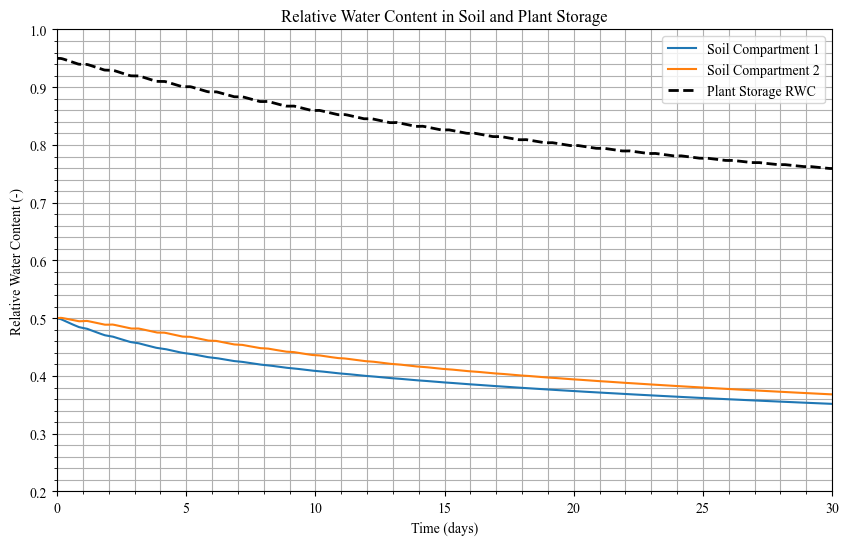

In [32]:
# Soil Moisture and Storage RWC Plot
fig_rwc = plt.figure(figsize=(10, 6))
plt.title('Relative Water Content in Soil and Plant Storage')
plt.xlabel("Time (days)")
plt.ylabel("Relative Water Content (-)")

# Plot each compartment
for j in range(num_compartments):
    plt.plot(timevec[0:daySteps*dispDuration], 
             results['s'][j][0:daySteps*dispDuration], 
             label=f'Soil Compartment {j+1}')

plt.plot(timevec[0:daySteps*dispDuration], 
         results['w'][0:daySteps*dispDuration], 
         'k--', linewidth=2, label='Plant Storage RWC')

plt.xlim(0, dispDuration)
plt.ylim(0.2, 1)
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.show()

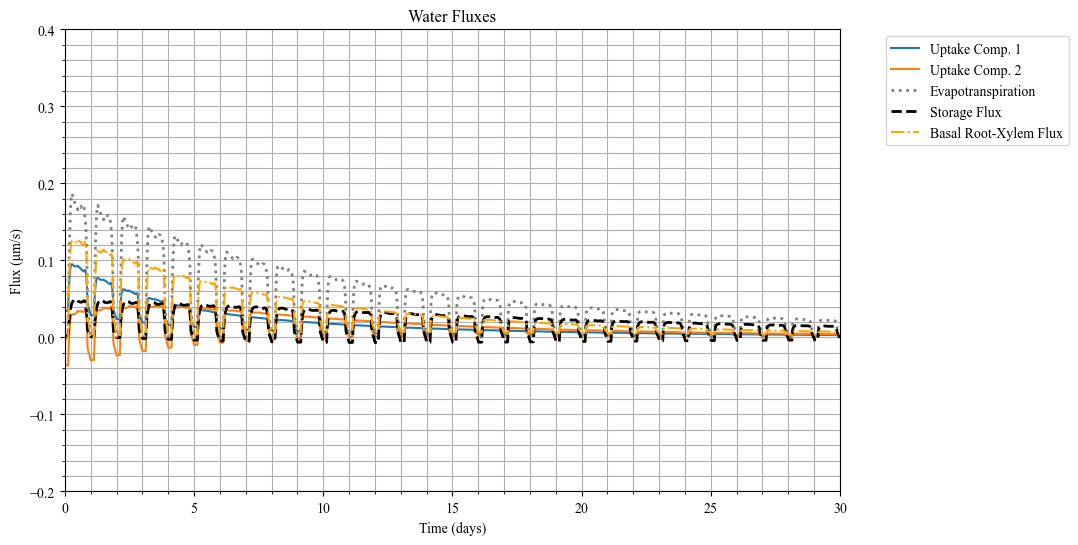

In [33]:
# Water Fluxes Plot
fig_fluxes = plt.figure(figsize=(10, 6))
plt.title('Water Fluxes')
plt.ylabel("Flux (μm/s)")
plt.xlabel("Time (days)")

# Plot water uptake from each compartment
for j in range(num_compartments):
    plt.plot(timevec[0:daySteps*dispDuration], 
             results['qs'][j][0:daySteps*dispDuration], 
             label=f'Uptake Comp. {j+1}')

# Plot evapotranspiration
plt.plot(timevec[0:daySteps*dispDuration], 
         results['ev'][0:daySteps*dispDuration], 
         c='grey', linestyle=':', linewidth=2, label='Evapotranspiration')

# Plot storage flux
plt.plot(timevec[0:daySteps*dispDuration], 
         results['qw'][0:daySteps*dispDuration], 
         c='k', linestyle='--', linewidth=2, label='Storage Flux')

# Plot root-xylem flux
plt.plot(timevec[0:daySteps*dispDuration], 
         results['qbx'][0:daySteps*dispDuration], 
         c='orange', linestyle='-.', linewidth=1.5, label='Basal Root-Xylem Flux')

plt.xlim(0, dispDuration)
plt.ylim([-0.2, 0.40])
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

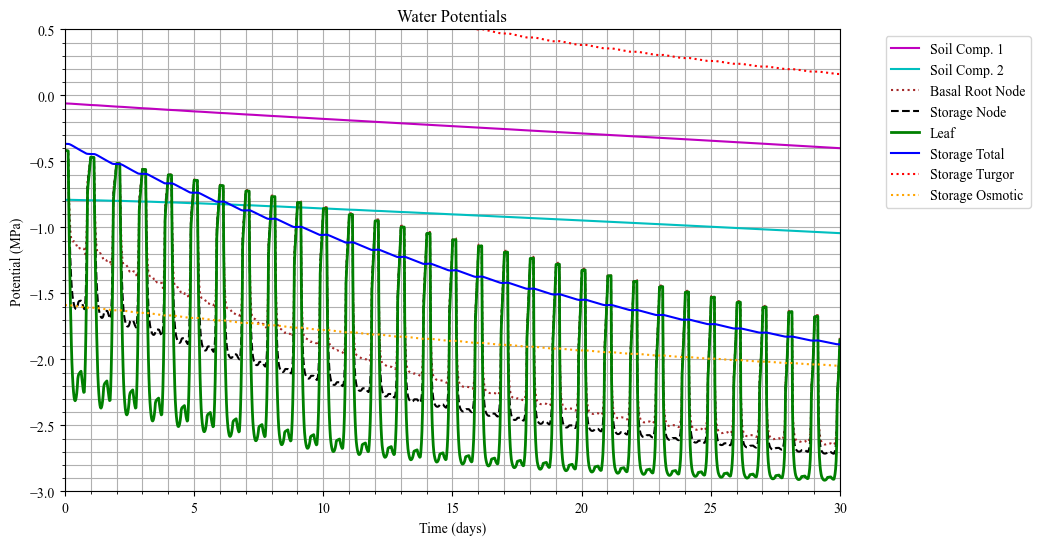

In [35]:
# Water Potentials Plot
fig_potentials = plt.figure(figsize=(10, 6))
plt.title('Water Potentials')
plt.ylabel('Potential (MPa)')
plt.xlabel("Time (days)")

# Plot soil water potential for each compartment
colors_soil = ['m-', 'c-']
for j in range(num_compartments):
    plt.plot(timevec[0:daySteps*dispDuration], 
             results['psi_s'][j][0:daySteps*dispDuration], 
             colors_soil[j], label=f'Soil Comp. {j+1}')

# Plot basal potential
plt.plot(timevec[0:daySteps*dispDuration], 
         results['psi_b'][0:daySteps*dispDuration], 
         'brown', linestyle=':', label='Basal Root Node')

# Plot xylem junction potential
plt.plot(timevec[0:daySteps*dispDuration], 
         results['psi_x'][0:daySteps*dispDuration], 
         'k--', label='Storage Node')

# Plot leaf water potential
plt.plot(timevec[0:daySteps*dispDuration], 
         results['psi_l'][0:daySteps*dispDuration], 
         'g-', linewidth=2, label='Leaf')

# Plot plant storage potentials
plt.plot(timevec[0:daySteps*dispDuration], 
         results['psi_w'][0:daySteps*dispDuration], 
         'b-', label='Storage Total')

plt.plot(timevec[0:daySteps*dispDuration], 
         results['psi_w_turgor'][0:daySteps*dispDuration], 
         'r:', label='Storage Turgor')

plt.plot(timevec[0:daySteps*dispDuration], 
         results['psi_w_osm'][0:daySteps*dispDuration], 
         'orange', linestyle=':', label='Storage Osmotic')

plt.xlim(0, dispDuration)
plt.ylim([-3, 0.5])
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

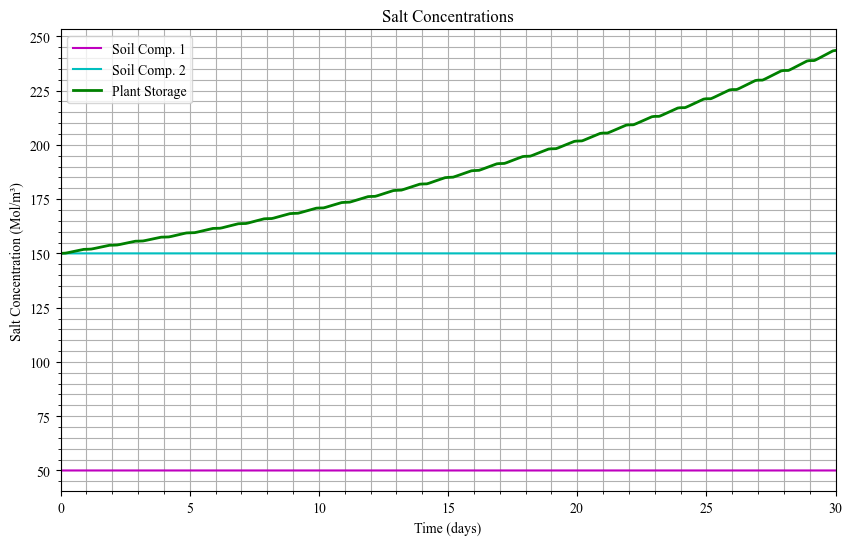

In [ ]:
# # Salt Concentrations Plot
# fig_salt = plt.figure(figsize=(10, 6))
# plt.title('Salt Concentrations')
# plt.ylabel('Salt Concentration (Mol/m³)')
# plt.xlabel("Time (days)")

# # Plot soil salt concentration for each compartment
# colors_salt = ['m-', 'c-']
# for j in range(num_compartments):
#     plt.plot(timevec[0:daySteps*dispDuration], 
#              results['cs'][j][0:daySteps*dispDuration], 
#              colors_salt[j], label=f'Soil Comp. {j+1}')

# # Plot plant storage salt concentration
# plt.plot(timevec[0:daySteps*dispDuration], 
#          results['cw'][0:daySteps*dispDuration], 
#          'g-', linewidth=2, label='Plant Storage')

# plt.xlim(0, dispDuration)
# plt.xticks(np.arange(0, dispDuration+1, 5))
# plt.minorticks_on()
# plt.grid(visible=True, which='both', axis='both')
# plt.legend()
# plt.show()

In [ ]:
# Plant Water Storage and Salt Concentration with Dual Axes
fig_storage, ax1 = plt.subplots(figsize=(10, 6))
fig_storage.suptitle('Plant Water Storage and Salt Concentration')

# Left axis: Plant water content (w)
ax1.plot(timevec[0:daySteps*dispDuration], 
         results['w'][0:daySteps*dispDuration], 
         'b-', linewidth=2, label='Plant Water Content')
ax1.set_ylabel('Plant Water Content (m³/m³)', color='b')
ax1.set_ylim(0, 1.05)
ax1.set_xlim(0, dispDuration)
ax1.set_xlabel('Time (days)')
ax1.tick_params(axis='y', labelcolor='b')

# Right axis: Plant salt concentration (cw)
ax2 = ax1.twinx()
ax2.plot(timevec[0:daySteps*dispDuration], 
         results['cw'][0:daySteps*dispDuration], 
         'g-', linewidth=2, label='Plant Salt Concentration')
ax2.set_ylabel('Plant Salt Concentration (Mol/m³)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Combined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
ax1.minorticks_on()
ax1.grid(visible=True, which='both', axis='both')
ax1.set_xticks(np.arange(0, dispDuration+1, 5))
plt.show()